# このファイルについて
## 頭が悪いコードなので直してくれるとうれしいな( *´艸｀)

擾乱に対する位置制御のために必要な燃料を推算します。

In [13]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import pickle

In [45]:
MU = 3.986*10**5#地球重力定数[km^3/s^2]
R_po = 6600.#パーキング軌道半径[km]
Delta_i = 30.#種子島の緯度[deg]
PI = np.pi
J2 = 1082.628*10**(-6)#J2帯状調和関数係数
R_e = 6

G = 9.81 #重力加速度[m/s^2]
R_earth = 6378 #地球の半径[km]
SCALE_HEIGHT = 8.432#スケールハイト[km]
RHO_0 = 1.225#標準大気密度[kg/m^3]
H_reEntry = 200 #大気圏高度[km]
M_earth = 5.9724*10**24
## すまん、ここ詰める必要あるな
v_reEntry = 8.0 #再突入の速度(一例)[km/s]
gamma_reEntry = -5.0 #再突入時の経路角(結構浅め)[deg]

#機体によるので、あとで
M_capcell = 80.0 #はやぶさ参照[kg]
A = 0.2 #ハヤブサよりちょい大きめ[kg]
Rn = 0.2#てきとー

#なんかを参照
Cd = 1.6
Cl = 0.0
DT = 0.1#刻み

In [15]:
alpha = 28.58
alpha = np.deg2rad(alpha)
delta_moon = 102.67*np.cos(alpha)*np.sin(alpha)
print(delta_moon)
gamma = 23.44
gamma = np.deg2rad(alpha)
delta_sun = 40.17*np.cos(gamma)*np.sin(alpha)
print(delta_sun)

43.13106201760243
19.216011456044555


## 軌道投入推進重量の概算
半径6600kmから高度1200kmまでのホーマン軌道に入れた後、
高度1200kmにおける減速量を計算する。
\begin{align*}
    v_{p@before} = \sqrt{2\mu\left(\frac{1}{r_p}-\frac{1}{r_a+r_p}\right)} \\
    v_{p@after} = \sqrt{\frac{\mu}{r_p}}
\end{align*}

In [16]:
def get_prop_phase1(h_tgt=1200, r_po=R_po, mf=300, Isp=220):
    """
    h_tgt[km] フェーズ2の周回軌道高度
    h_po[km] POの高度
    mf[kg] ドライ重量(フェーズ３除く)
    Isp[s] Isp
    """
    mf = mf+50
    r_tgt = h_tgt+R_earth
    v_a_before = np.sqrt(2*MU*(1./r_tgt-1./(r_tgt+r_po)))
    v_a_after = np.sqrt(MU/r_tgt)
    delta_v = v_a_after-v_a_before
    print(delta_v)
    mp = mf*(np.exp(delta_v*10**3/G/Isp) -1)
    print(mp)
    return None
get_prop_phase1()

0.254610415127404
43.82500383306236


# 再突入のΔｖ概算
## to do
大気とか概算なので、ちゃんと後でどっかのデータ引用した方がよい

おそらく高度20㎞とかでパラシュート展開するのかな
## 大気圏内の支配方程式
\begin{align*}
\frac{dv}{dt} = \ddot{x} =-\frac{D}{m} - g\sin\gamma \\
v\frac{d\gamma}{dt} = \frac{L}{m} - g\cos\gamma + \frac{v^2}{r}\cos{\gamma}
\end{align*} 

In [17]:
def dominant_eq(D,L,gamma,v,r, M=M_capcell):
    gamma_rad = np.deg2rad(gamma)
    dot_r = v*np.sin(gamma_rad)
    dot_v = -D/M*10**3-G*np.sin(gamma_rad)*10**(-3)
    dotgamma_rad = L/(M*v)*10**3-G*np.cos(gamma_rad)/v*10**(-3)+v*np.cos(gamma_rad)/r
    dot_gamma = np.rad2deg(dotgamma_rad)
    return dot_r,dot_v,dot_gamma

def get_density(h):
    return RHO_0*np.exp(-h/SCALE_HEIGHT)
def get_precise_density(z):
    matrix = np.array([[0.000000,-3.322622E-6,9.111460E-4,-0.2609971,5.944694],
                       [0.000000,2.873405E-5,-0.008492037,0.6541179,-23.62010],
                       [-1.240774E-5,0.005162063,-0.8048342,55.55996,-1443.338],
                       [0.00000,-8.854164E-05,0.03373254,-4.390837,176.5294],
                       [3.661771E-7,-2.154344E-4,0.04809214,-4.884744,172.3597],
                       [1.906032E-8,-1.527799E-5,0.004724294,-0.6992340,20.50921],
                       [1.199282E-9,-1.451051E-6,6.910474E-4,-0.1736220,-5.321644],
                       [1.140564E-10,-2.130756E-7,1.570762E-4,-0.07029296,-12.89844],
                       [8.105631E-12,-2.358417E-9,-2.635110E-6,-0.01562608,-20.02246],                    
                       [-3.701195E-12,-8.608611E-9,5.118829E-5,-0.06600998,-6.137674]])
    Zs = np.array([z**4,z**3,z**2,z**1,1])
    if z>750:
        i = 9
        rho = np.exp(Zs@matrix[i])
    elif z>500:
        i = 8
        rho = np.exp(Zs@matrix[i])    
    elif z>300:
        i = 7
        rho = np.exp(Zs@matrix[i])    
    elif z>200:
        i = 6
        rho = np.exp(Zs@matrix[i])   
    elif z>150:
        i = 5
        rho = np.exp(Zs@matrix[i])    
    elif z>120:
        i = 4
        rho = np.exp(Zs@matrix[i])        
    elif z>110:
        i = 3
        rho = np.exp(Zs@matrix[i])    
    elif z>100:
        i = 2
        rho = np.exp(Zs@matrix[i])        
    elif z>91:
        i = 1
        rho = np.exp(Zs@matrix[i])        
    elif z>86:
        i = 0
        rho = np.exp(Zs@matrix[i])
    else:
        rho = RHO_0*np.exp(-z/SCALE_HEIGHT)
    
    return rho

def get_Drag_Lift(v,rho, S=A):
    D = 1/2*rho*v**2*S*Cd
    L = 1/2*rho*v**2*S*Cl
    return D,L

def f(h, v, gamma):
    rho = get_precise_density(h)
    D,  L = get_Drag_Lift(v, rho)
    r = h + R_earth
    dot_r, dot_v, dot_gamma = dominant_eq(D, L, gamma, v, r)
    return np.array([dot_r, dot_v, dot_gamma])

def re_entry(v_reEntry,gamma_reEntry):
    h = H_reEntry
    v = v_reEntry
    gamma = gamma_reEntry
    heating_rate = 1.35*10**(-8)*np.sqrt(get_precise_density(h)/Rn)*(v*10**3)**3.04 *10
    t = 0
    t_lst = [t]
    h_lst = [h]
    v_lst = [v]
    gamma_lst= [gamma]
    heating_rate_lst = [heating_rate]
    while 0 <= h <= H_reEntry:
        k1_vector = f(h, v, gamma)*DT
        k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
        k1_h = k1_r
        
        k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2)*DT
        k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
        k2_h = k2_r

        k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2)*DT
        k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
        k3_h = k3_r

        k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma)*DT
        k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
        k4_h = k4_r

        delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
        delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
        delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
        ####################################
        h += delta_r_euqual_h
        v += delta_v
        gamma += delta_gamma
        t += DT
        heating_rate = 1.35*10**(-8)*np.sqrt(get_precise_density(h)/Rn)*(v*10**3)**3.04 *10
        t_lst.append(t)
        h_lst.append(h)
        v_lst.append(v)
        gamma_lst.append(gamma)
        heating_rate_lst.append(heating_rate)
    if h_lst[-1] >= H_reEntry:
        #大気に弾かれた場合
        print(h_lst[-1])

    else:
        #print("カプセル帰還")
        pass
    return t_lst, h_lst, v_lst, gamma_lst, heating_rate_lst

In [18]:
import matplotlib as mpl
import matplotlib.font_manager as fm

font = {"family":"Noto Sans CJK JP"}
mpl.rc('font', **font)

#fm.findSystemFonts()

C:\Users\msy-o\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Noto Sans CJK JP'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


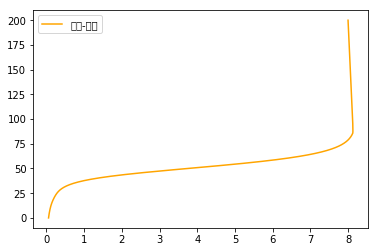

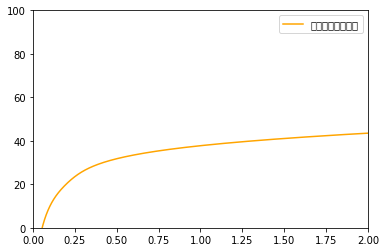

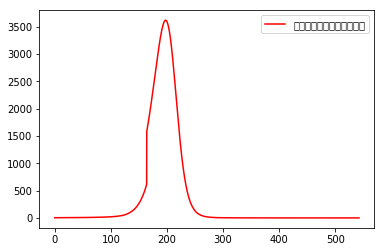

In [19]:
a, b, c, d, e = re_entry(v_reEntry, gamma_reEntry)
plt.plot(c, b, color='orange',label='高度-速度')
plt.legend()
plt.show()

plt.plot(c, b, color='orange', label='より小さいところ')
plt.xlim(0,2)
plt.ylim(0,100)
plt.legend()
plt.show()

plt.plot(a, e, color='red',label='空力加熱率高すぎいいいい')
plt.legend()
plt.show()

In [20]:
v_ent_lst = np.arange(5,15,1)
gamma_ent = -8
#plt.figure(figsize=(6,8))
height_lst = []
v_lst = []
heat_lst = []
for v_ent in v_ent_lst:
    #print(v_ent)
    time, height, v, gamma, heat_rate = re_entry(v_ent, gamma_ent)
    height_lst.append(height)
    v_lst.append(v)
    heat_lst.append(heat_rate)


200.11440291272652
200.1536623685035
200.15845775299445


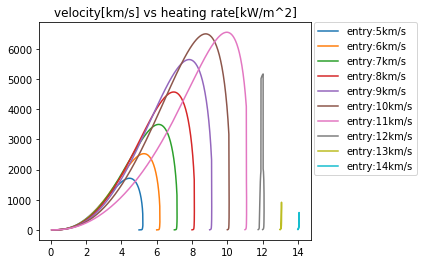

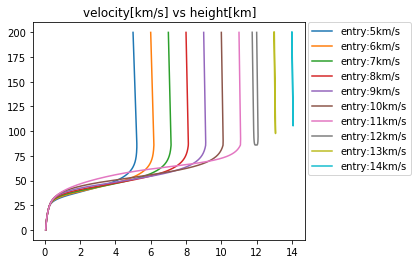

In [21]:
for i in range(len(v_lst)):
    plt.plot(v_lst[i], heat_lst[i], label="entry:"+str(v_ent_lst[i])+"km/s")
    plt.title("velocity[km/s] vs heating rate[kW/m^2]")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(left = 0.1, right = 0.73)
plt.savefig('../output/reentry_v-heatrate.png',dpi=100)
plt.show()

for i in range(len(v_lst)):
    plt.plot(v_lst[i], height_lst[i], label="entry:"+str(v_ent_lst[i])+"km/s")
    plt.title("velocity[km/s] vs height[km]")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(left = 0.1, right = 0.73)  
plt.savefig('../output/reentry_v-height.png',dpi=100)
plt.show()

In [22]:
v_ent_lst = np.arange(5,15,1)
gamma_ent_lst = np.arange(-15,-8,1)
max_heat_lst = np.zeros((len(gamma_ent_lst),len(v_ent_lst)))
for i in range(len(v_ent_lst)):
    for j in range(len(gamma_ent_lst)):
        _, _, _, _, heating_rate = re_entry(v_ent_lst[i], gamma_ent_lst[j])
        max_heat_lst[j,i] = max(heating_rate)
X, Y = np.meshgrid(v_ent_lst, gamma_ent_lst)
Z = max_heat_lst

200.08654022090704


No handles with labels found to put in legend.


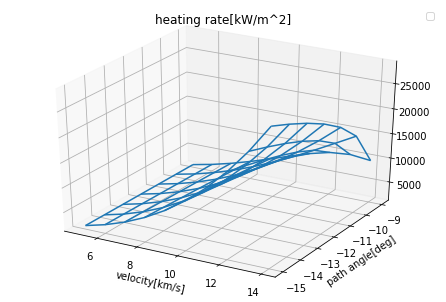

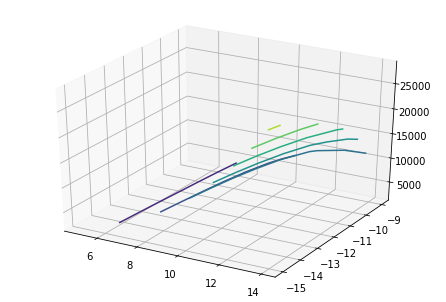

In [23]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,Z)
plt.xlabel("velocity[km/s]")
plt.ylabel("path angle[deg]")
plt.title("heating rate[kW/m^2]")
plt.legend()
plt.savefig("../output/reentry_condition_map.png", dpi=100)
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.contour3D(X,Y,Z)
plt.show()

In [24]:
class Dicision_Entry():
    def __init__(self):
        pass
    def solve(self):
        pass

## 再突入速度の決定
後で、アブレータを設計できるとして、ここでは
\begin{align*}
q < 4000 [kW/m^2]
\end{align*}
として、設計を進めるものとする。これより、再突入における条件を
\begin{align*}
v_{entry} = 8.0[km/s]\\
\gamma_{entry} = -9.0[deg]
\end{align*}
とする。

In [25]:
v_entry = 9.
gamma_entry = -8.

# 必要燃料@帰還時の推算
## 方針
1. 大気圏突入速度を決める←多分、決め打ち
2. そこから逆算して、アポジキック(逆噴射)決定

## 使う方程式
以下
\begin{align*}
\alpha = \frac{rv^2}{\mu}
\end{align*}
とすると、
### 離心率の決定
\begin{align*}
e = \sqrt{(\alpha-2)\alpha\cos^2\gamma+1}
\end{align*}
### 遷移軌道時の軌道長半径の決定
\begin{align*}
r_a = \frac{1+e\cos\theta}{1-e^2}r
\end{align*}
この辺いらんな。。。。一応デバッグ要員として

角運動量一定より、
\begin{align*}
v_{@apo} = \frac{h}{r_{@apo}} = \frac{r_{entry}v_{entry}\cos\gamma_{entry}}{r_{circuit}}
\end{align*}
が燃料噴射直後の速さなので、
\begin{align*}
\Delta v = v_{circuit}-v_{@apo}
\end{align*}
が減速量で、燃料を最終質量$m_f$(カプセル重量から引っ張ってくる)から逆算して
\begin{align*}
m_{prop_{@return}} = m_f\left(e^{\frac{\Delta v}{gI_{sp}}}-1\right)
\end{align*}


離心率は0.36132500854857197
真近点離角は-0.535023009127491
半長軸の長さ9917.433108154106[km]
減速前の速さ7.252560272715369[km/s]
減速後の速さ7.736322275750653[km/s]


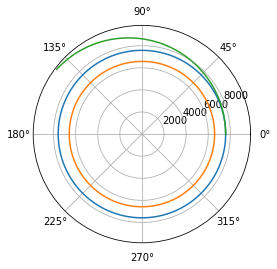

減速量-0.4837620030352836[km/s]
燃料は-60.24158981494002[kg]


In [37]:
def get_prop(r0, r, v, gamma, mf=300, Isp=220):
    """
    ある点の情報がわかれば、遠地点(仮)での推進剤重量がわかり幸せになれる
    arg:
        r0[km] 周回軌道半径(遠地点(仮))
        ####遠地点
        r[km] ある地点でのr
        v[km/s] ある地点での速さ
        gamma[deg] ある地点での経路角
        
        mf[kg] 最終重量(本体ごと突っ込む)
                default:300kg(はやぶさ参照)
        Isp[s] 燃料のIsp
                default:220(???????????????)
        
    return:
        mp[kg] 必要燃料重量
                
    
    """
    gamma = np.deg2rad(gamma)
    alpha = r*v**2/MU#無次元数の何か
    h = r*v*np.cos(gamma)
    l = h**2/MU
    theta = np.arange(0,2*PI, 0.01)
    #離心率の決定(楕円軌道前提)--間違っている
    eccentricity = np.sqrt((alpha-2)*alpha*(np.cos(gamma))**2+1)
    print("離心率は{}".format(eccentricity))
    r_tgt = l/(1+eccentricity*np.cos(theta))
    r0_lst = [r0 for i in range(len(theta))]
    r_lst = [r for i in range(len(theta))]
    #plt.polar(theta, r_tgt)
    plt.polar(theta, r0_lst)
    plt.polar(theta, r_lst)
    #plt.show()
    #真近点離角
    tan_true_anomaly = alpha*np.sin(gamma)*np.cos(gamma)/(alpha*(np.cos(gamma))**2-1)
    true_anomaly = math.atan(tan_true_anomaly)
    print("真近点離角は{}".format(true_anomaly))
    
    #半長軸の決定
    semi_major_axis = (1+eccentricity*np.cos(true_anomaly))*r/(1-eccentricity**2)
    print("半長軸の長さ{}[km]".format(semi_major_axis))
    
    #燃料噴出"前"の速さ
    print("減速前の速さ{}[km/s]".format(np.sqrt(MU/r0)))
    #燃料噴出"直"後の速さ
    v0 = r*v*np.cos(gamma)/r0
    print("減速後の速さ{}[km/s]".format(v0))
    alpha0 = r0*v0**2/MU
    e0 = alpha0-1
    theta2 = np.arange(0, 2.5, 0.01)
    r_tgt2 = l/(1+e0*np.cos(theta2))
    plt.polar(theta2, r_tgt2)
    plt.show()
    delta_v = np.sqrt(MU/r0) - v0
    print("減速量{}[km/s]".format(delta_v))
    
    mp = mf*(np.exp(delta_v*10**3/G/Isp) -1)
    print("燃料は{}[kg]".format(mp))
    
    return None

R0 = R_earth +1200
R1 = R_earth + 200
get_prop(R0, R1, v=v_entry, gamma=gamma_entry)

In [40]:
## min
Rp = R_earth+200
Ra = R_earth+1200
Vp = np.sqrt(2*MU*(1/Rp-1/(Rp+Ra)))
Va = np.sqrt(2*MU*(1/Ra-1/(Rp+Ra)))
print("一応定常飛行時:{0}km/s".format(np.sqrt(MU/Ra)))
print("最小燃料の遠地点速度Va:{0}km/s".format(Va))
print("最小燃料の近地点速度Vp:{0}km/s".format(Vp))

一応定常飛行時:7.252560272715369km/s
最小燃料の遠地点速度Va:6.991703490667863km/s
最小燃料の近地点速度Vp:8.054595477695509km/s


## 逆ホーマンの遠地点速度の決定
上より、
\begin{align*}
v_{trans@apo} \leq 7.00~\rm{[km/s]}  
\end{align*}
この範囲で、さらに絞る。

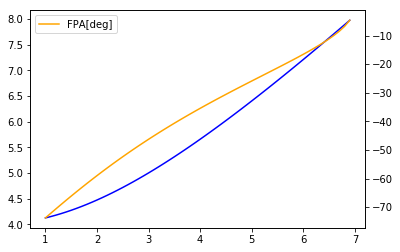

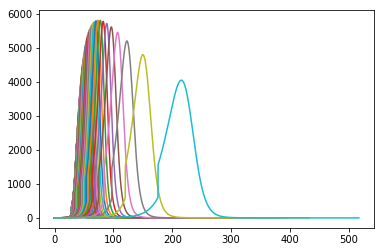

In [51]:
v_trans_apo_lst = np.arange(1.00, 7.00, 0.1)
#大気圏突入速度と経路角を決定する。
Re = R_earth+200
v_entry_lst = np.zeros_like(v_trans_apo_lst)
fpa_entry_lst = np.zeros_like(v_trans_apo_lst)
for i in range(len(v_trans_apo_lst)):
    v_entry_lst[i] = np.sqrt(v_trans_apo_lst[i]**2 + 2*MU*(1/Re-1/Ra))
    fpa_entry_lst[i] = np.rad2deg(-np.arccos(v_trans_apo_lst[i]*Ra/v_entry_lst[i]/Re))

fig, ax1 = plt.subplots()
ax1.plot(v_trans_apo_lst, v_entry_lst, color='blue', label='v_entry[km/s]')
ax2 = ax1.twinx()
ax2.plot(v_trans_apo_lst, fpa_entry_lst, color='orange', label='FPA[deg]')
plt.legend()
plt.show()

#その後着陸までの軌道決定。
for i in range(len(v_trans_apo_lst)):
    t_atm_lst, h_atm_lst, v_atm_lst, gamma_atm_lst, heatflux_atm_lst \
        =re_entry(v_entry_lst[i], fpa_entry_lst[i])
    plt.plot(t_atm_lst, heatflux_atm_lst)
plt.show()

In [27]:
#擾乱の永年項を計算
#計算量多めなので、後で直す
def gravity_perturbation_moon(r, i):
    """
    月の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_moon(float) 近地点引数の変化[deg/day]
    dot_Omega_moon(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_moon = -0.00338*np.cos(i)/n
    dot_omega_moon = 0.00169*(4-5*(np.sin(i))**2)/n
    return dot_Omega_moon, dot_omega_moon

def gravity_perturbation_sun(r, i):
    """
    太陽の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_sun(float) 近地点引数の変化[deg/day]
    dot_Omega_sun(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_sun = -0.00154*np.cos(i)/n
    dot_omega_sun = 0.00077*(4-5*((np.sin(i))**2))/n
    return dot_Omega_sun, dot_omega_sun

print(gravity_perturbation_sun(6700, 28))

(-8.58944949611711e-05, 0.0001409600776584566)


In [28]:
class Orbit:
    """なんか軌道わかるとうまくいくやつ()
    to do
    外乱制御用のΔV
    """
    
    def __init__(self, r_tgt):
        """とりあえず円周回軌道半径だけ。。。"""
        self.r_tgt = r_tgt # radius of orbit
        self.delta_v_peri = None
        self.delta_v_apo = None
        self.delta_v = None
        
        self.reentry_height = 100 #地球の大気圏高度[km]
        self.v_tgt = None
    def get_delta_v_peri(self):
        """近地点でのΔv"""
        r_tgt = self.r_tgt
        v_po = np.sqrt(MU/R_po)
        v_peri_trans = np.sqrt(2*MU*r_tgt/R_po/(R_po+r_tgt))
        self.delta_v_peri = v_peri_trans - v_po

    def get_delta_v_apo(self):
        """遠地点でのΔv"""
        r_tgt = self.r_tgt
        self.v_tgt = np.sqrt(MU/r_tgt)
        v_apo_trans = np.sqrt(2*MU*R_po/r_tgt/(R_po+r_tgt))
        self.delta_v_apo = self.v_tgt-v_apo_trans
    
    def j2(self):
        """
        外乱J2項考えましょうね～～～～～～～～～～
        """
    
    def get_delta_v(self):
        """Δv全部"""
        self.get_delta_v_peri()
        self.get_delta_v_apo()
        self.delta_v = self.delta_v_apo+self.delta_v_peri
        print("Delta V: {0} [km/s]".format(self.delta_v))
        print("V at tgt: {}[km/s]".format(self.v_tgt))

In [29]:
orb = Orbit(7200.)
orb.get_delta_v()

Delta V: 0.3306925582501039 [km/s]
V at tgt: 7.440504761849906[km/s]


# 空気抵抗による落下の推算

空気抵抗による高度落下を計算。  
\begin{align*}
\frac{dr}{dt} = -\frac{\rho V C_d A_s r}{m} = -\rho \frac{C_d A_s}{m}\sqrt{GMr}
\end{align*}

In [30]:
def get_drdt(r,Cd,As,m):
    """ r,drの単位は[km] """
    rho = get_density(r-R_earth)
    return (-rho*Cd*As*np.sqrt(G*M_earth*r*1000)/m) /1000

def solve_air_drag_eq(r0,dt=10**1,nstep=10**5,Cd_sat=2.2,As=20.,m_sat=500.):
    r_rev = [r0]
    for i in range(nstep):
        dr = get_drdt(r_rev[i],Cd_sat,As,m_sat)*dt
        new = r_rev[i] + dr
        if new > 0:
            r_rev.append(new)
        else:
            r_rev.append(R_earth)
    return r_rev[1:]

In [31]:
dt = 10**4
nstep = 10**4
r_rev = solve_air_drag_eq(380+R_earth,dt=dt,nstep=nstep)

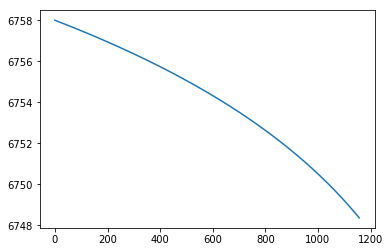

In [32]:
t = np.arange(0,nstep*dt,dt)/3600/24 # 単位はday
plt.plot(t,r_rev)

In [33]:
r_rev = solve_air_drag_eq(300+R_earth,dt=dt,nstep=nstep)